Dataset Loading

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("used-bikes.csv")  

df.head()

,Summary,url,Title,Post_Details,Bike Type,Brand,Trim/Edition,Model,Year,Mileage,Seller,Capacity,Price
0,"Atv beach bike 201435,000 kmKegalle, Motorbike...",https://ikman.lk/en/ad/atv-beach-bike-2014-for...,Atv beach bike 2014,"Posted on 30 Jan 9:02 am, Kegalle City, Kegalle",Quadricycles,Other brand,Atv beach bike,Other model,2014,"35,000 km",lakee,150 cc,"Rs 440,000"
1,"Bajaj Pulsar 150 palsar 201450,737 kmAnuradhap...",https://ikman.lk/en/ad/bajaj-pulsar-150-palsar...,Bajaj Pulsar 150 palsar 2014,"Posted on 11 Mar 1:58 pm, Kekirawa, Anuradhapura",Motorbikes,Bajaj,palsar 150,Pulsar 150,2014,"50,737 km",Sasila Ishan,150 cc,"Rs 370,000"
2,"Beach Buggy 20055,000 kmColombo, MotorbikesRs ...",https://ikman.lk/en/ad/beach-buggy-2005-for-sa...,Beach Buggy 2005,"Posted on 21 Jan 9:45 pm, Talawatugoda, Colombo",Quadricycles,Other brand,Beach Buggy,Other model,2005,"5,000 km",vinuka automart,125 cc,"Rs 210,000"
3,"Electra Alpha Vino 2019600 kmColombo, Motorbik...",https://ikman.lk/en/ad/electra-alfa-vino-2019-...,Electra Alpha Vino 2019,"Posted on 22 Feb 2:26 pm, Moratuwa, Colombo",E-bikes,Electra,Vino,Alpha,2019,600 km,Jeewantha Basnayaka,49 cc,"Rs 105,000"
4,"Hero Maestro Edge 201818,500 kmMEMBERKalutara,...",https://ikman.lk/en/ad/hero-maestro-edge-2018-...,Hero Maestro Edge 2018,"Posted on 07 Mar 2:08 pm, Bandaragama, Kalutara",Scooters,Hero,2018,Maestro Edge,2018,"18,500 km",Anjalee Motors,110 cc,"Rs 80,000"


Data Cleaning – Price Feature Processing

In [2]:
df["Price"] = df["Price"].str.replace("Rs", "", regex=False)
df["Price"] = df["Price"].str.replace(",", "", regex=False)
df["Price"] = df["Price"].astype(float)

Data Cleaning – Mileage Feature Processing

In [3]:
df["Mileage"] = df["Mileage"].str.replace(" km", "", regex=False)
df["Mileage"] = df["Mileage"].str.replace(",", "", regex=False)
df["Mileage"] = df["Mileage"].astype(float)

Data Cleaning – Capacity Feature Processing

In [4]:
df["Capacity"] = df["Capacity"].str.replace(" cc", "", regex=False)
df["Capacity"] = df["Capacity"].str.replace(",", "", regex=False)
df["Capacity"] = df["Capacity"].astype(float)

District Feature Extraction

In [5]:
df["District"] = df["Post_Details"].str.split(",").str[-1].str.strip()

Vehicle Age Feature Engineering

In [6]:
df["Vehicle_Age"] = 2024 - df["Year"]

Remove Extreme Vehicle Age Records

In [7]:
df = df[df["Vehicle_Age"] < 50]

Drop Unnecessary Columns

In [8]:
df = df.drop(columns=["Summary", "url", "Post_Details", "Seller", "Title"])

Interaction Feature Engineering

In [9]:
df["Mileage_per_Year"] = df["Mileage"] / (df["Vehicle_Age"] + 1)
df["CC_Age_Interaction"] = df["Capacity"] * df["Vehicle_Age"]
df["CC_Mileage_Interaction"] = df["Capacity"] * df["Mileage"]

Price Distribution Visualization

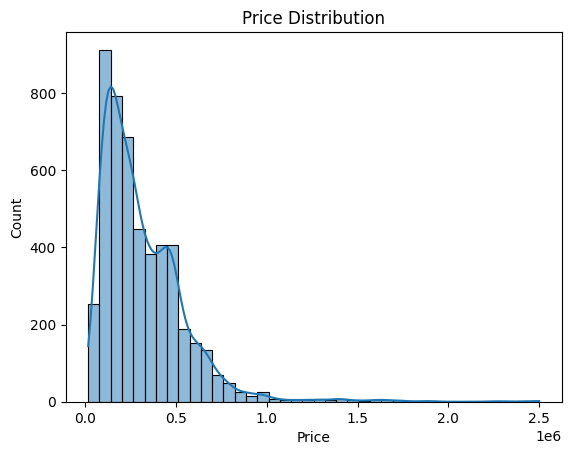

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["Price"], bins=40, kde=True)
plt.title("Price Distribution")
plt.show()

Log Transformation of Price

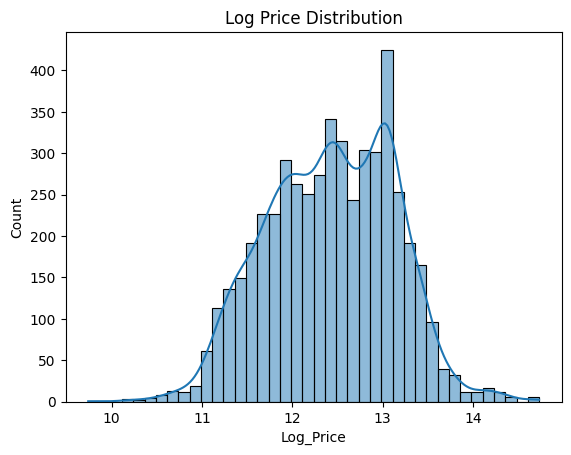

In [11]:
df["Log_Price"] = np.log1p(df["Price"])

sns.histplot(df["Log_Price"], bins=40, kde=True)
plt.title("Log Price Distribution")
plt.show()

Correlation Analysis

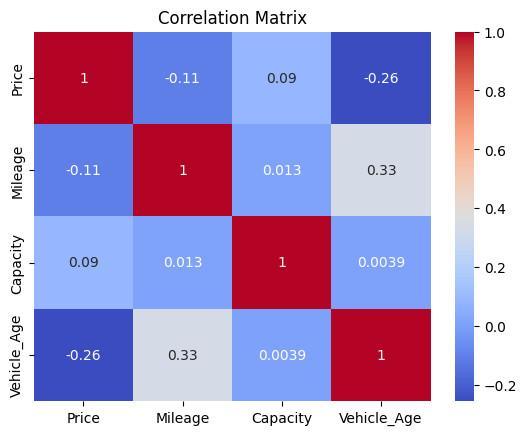

In [12]:
corr = df[["Price", "Mileage", "Capacity", "Vehicle_Age"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Categorical Feature Encoding

In [13]:
df_encoded = pd.get_dummies(
    df,
    columns=["Bike Type", "Brand", "Model", "District", "Trim/Edition"],
    drop_first=True
)

Define Features and Target Variable

In [14]:
X = df_encoded.drop(["Price", "Log_Price"], axis=1)
y = df_encoded["Log_Price"]

Check Remaining Object Columns

In [15]:
print(X.select_dtypes(include=["object"]).columns)

Index([], dtype='object')


Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train XGBoost Regression Model

In [17]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Initial Model Evaluation

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_log = model.predict(X_test)

# Convert back
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

RMSE: 133939.8225071183
MAE : 92605.98364671611
R2  : 0.5780723147719218


Hyperparameter Tuning using RandomizedSearchCV

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

param_dist = {
    "n_estimators": [300, 500, 700, 900],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0.3]
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,         
    scoring="r2",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}


Evaluate Best Model

In [20]:
best_model = random_search.best_estimator_

y_pred_log = best_model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

RMSE: 132760.2253760756
MAE : 91900.57661001371
R2  : 0.585471354958228


Mean Absolute Percentage Error Calculation

In [21]:
import numpy as np

mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100
print("MAPE:", mape, "%")

MAPE: 42.36410355208431 %


Model Explainability using SHAP

In [22]:
import shap

explainer = shap.TreeExplainer(best_model)   
shap_values = explainer.shap_values(X_test)

/Users/ramajinig/Desktop/MLPreAssignment/Final Assignment /214024V/bike_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP Summary Plot

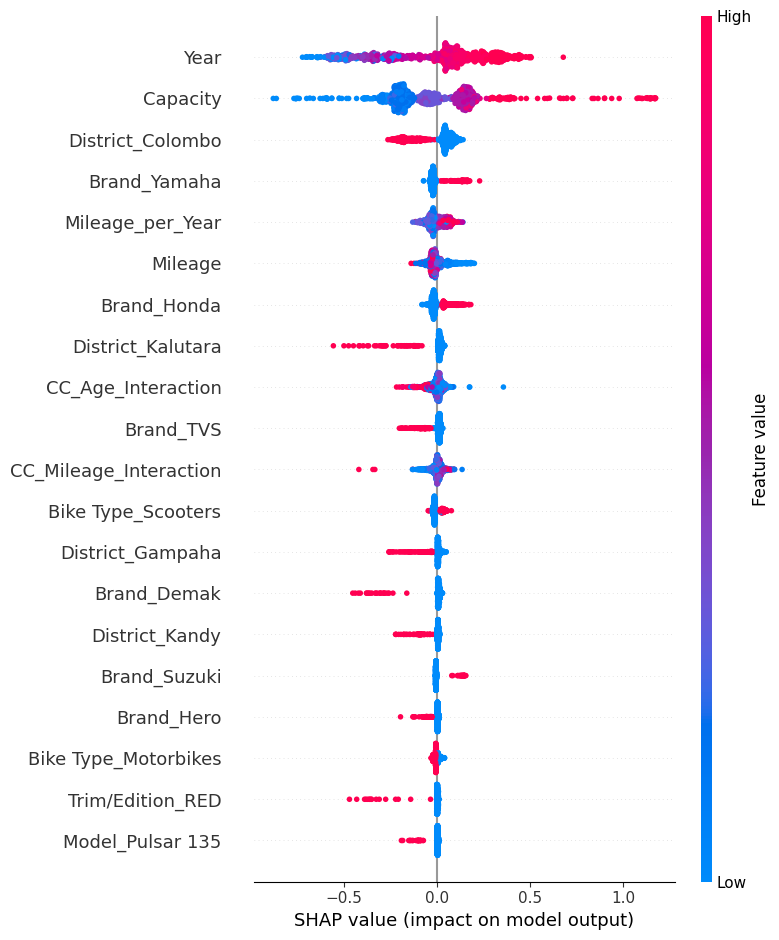

In [23]:
shap.summary_plot(shap_values, X_test)

SHAP Feature Importance Bar Plot

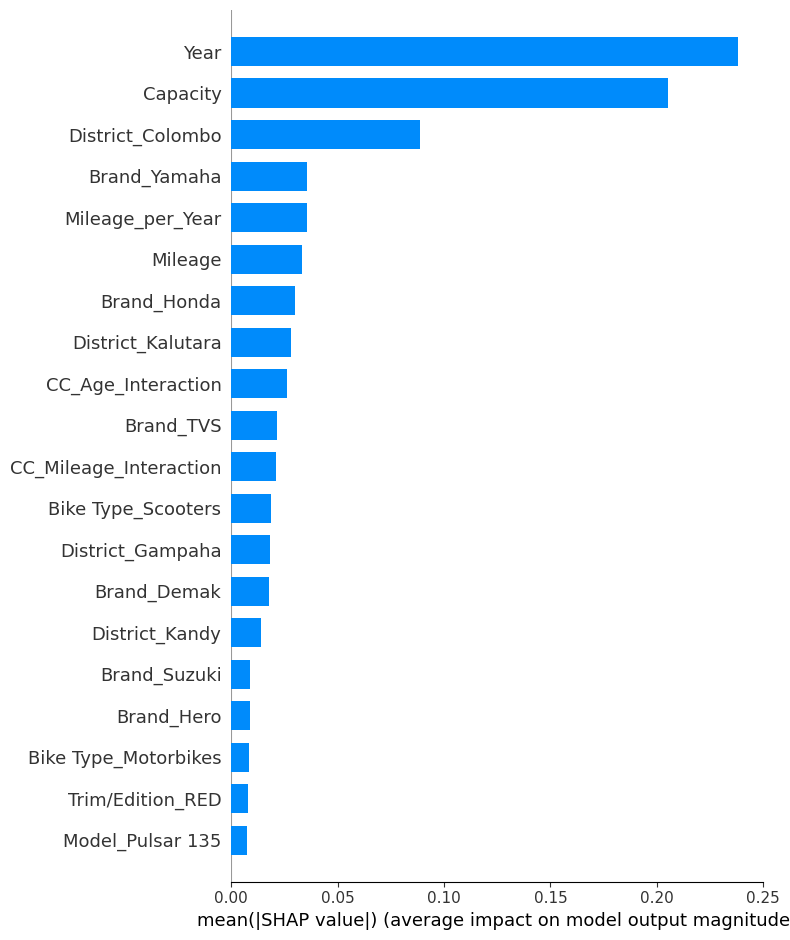

In [24]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

SHAP Dependence Plot

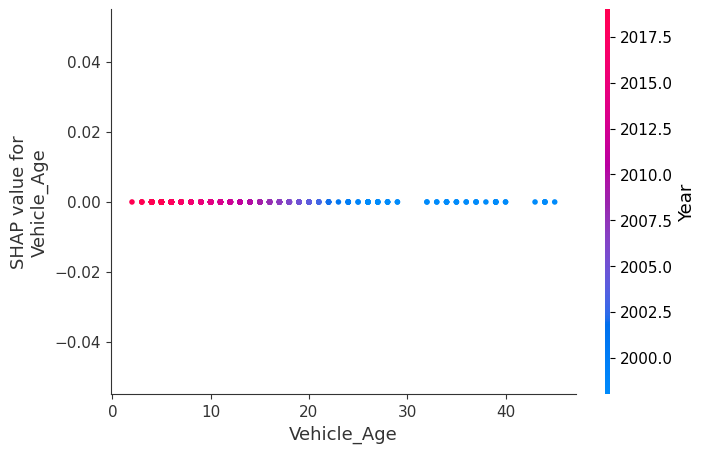

In [25]:
shap.dependence_plot("Vehicle_Age", shap_values, X_test)

SHAP Waterfall Plot

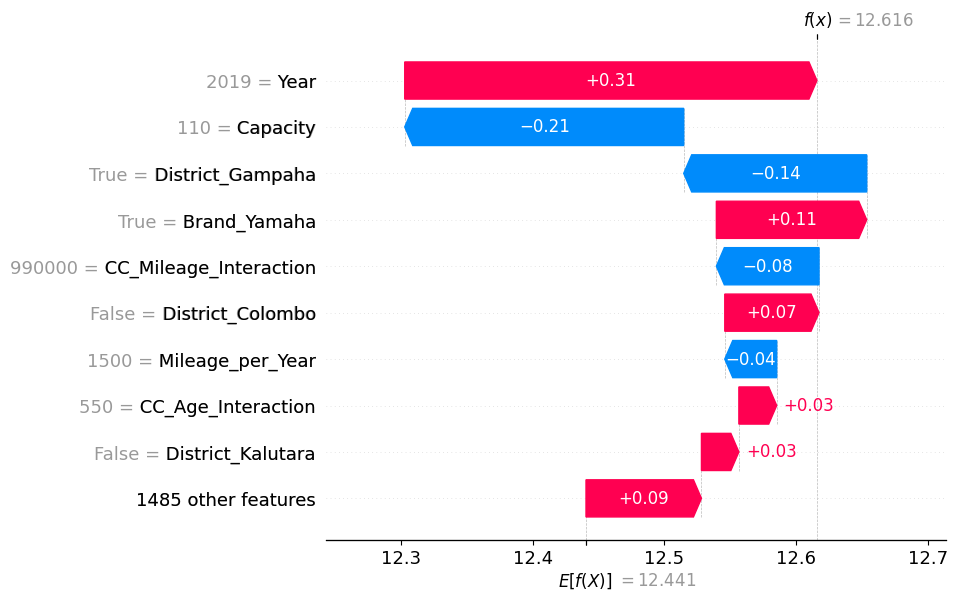

In [26]:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_test.iloc[0],
        feature_names=X_test.columns
    )
)

SHAP Feature Importance Bar Plot

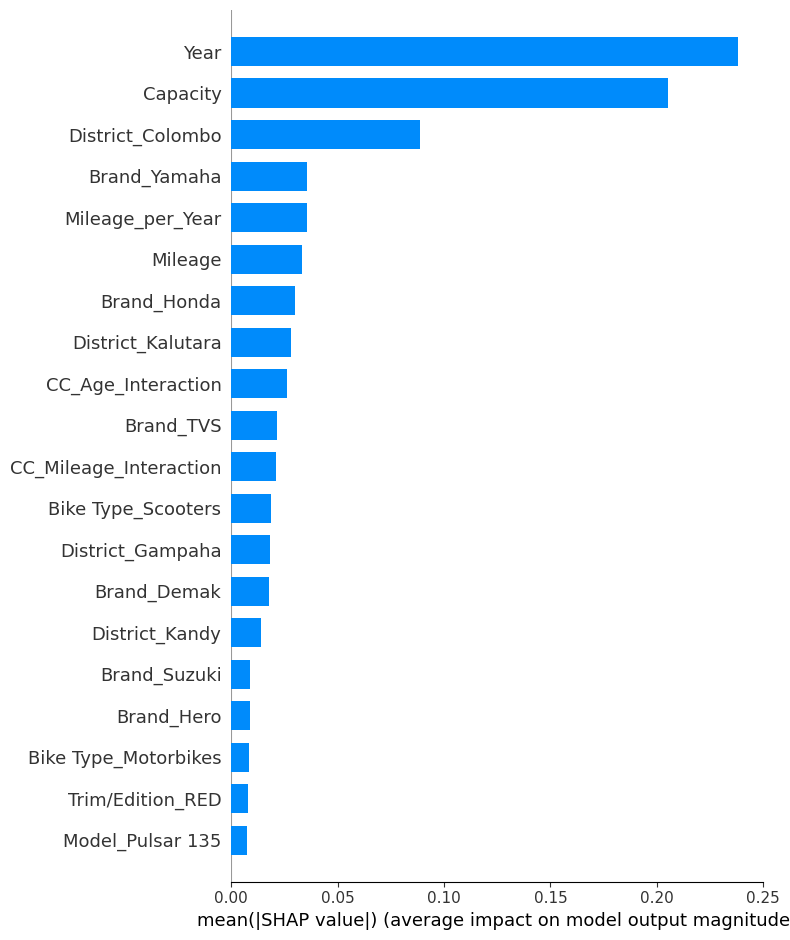

In [27]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Save Trained Model and Metadata

In [28]:
best_model.save_model("bike_price_xgb.json")

import pickle

with open("model_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

background = X_train.sample(min(200, len(X_train)), random_state=42)

with open("shap_background.pkl", "wb") as f:
    pickle.dump(background, f)

print("Files saved successfully.")

Files saved successfully.
